In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
# from time import time
from Thermo_evo import diffusion1d, advect1d, compute_tt
from TChron_PINNs import PINN1D, PINN1DSolver
import matplotlib.pyplot as plt

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
tf.get_logger().setLevel('ERROR')

2023-08-14 17:49:21.412608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 17:49:21.554070: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
%matplotlib inline

SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', family='Arial', size=SIZE) # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize

In [3]:
def logistic_f(x, a=0, L=1, k=1, x0=0):
    return a + L / (1 + np.exp(-k * (x - x0)))

tf_logistic = lambda t, a, L, k, x0: a + L * tf.math.sigmoid(k * (t - x0))

In [18]:
t_end = 50.
h = 20.
Tsurf = 0.
Tbot = 500.
Tgrad0 = (Tbot - Tsurf) / h
kappa = 25.
u0, u1, t1 = .05, .8, 35
uplift = lambda t : logistic_f(t, a=u0, L=u1, k=2, x0=t1)
tf_uplift = lambda t: tf_logistic(t, u0, u1, 2, t1)

In [5]:
# Define the initial condition
def T_init(z):
    return Tbot - Tgrad0 * z

# Define boundary condition
def T_surf(z):
    return tf.constant(Tsurf, shape=z.shape, dtype=DTYPE)

def T_bot(z):
    return tf.constant(Tbot, shape=z.shape, dtype=DTYPE)

In [6]:
# Set number of data points
N_0 = 50
N_b = 50
N_r = 1000

# Set boundary
tmin = 0.
tmax = t_end
zmin = 0.
zmax = h

# Lower bounds
lb = tf.constant([tmin, zmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, zmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(128)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0, 1), dtype=DTYPE) * lb[0]
z_0 = tf.random.uniform((N_0, 1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, z_0], axis=1)

# Evaluate intitial condition at z_0
T_0 = T_init(z_0)

# Boundary data
t_b = tf.random.uniform((N_b*2, 1), lb[0], ub[0], dtype=DTYPE)
z_b = lb[1] * tf.ones((N_b, 1), dtype=DTYPE)
z_s = ub[1] * tf.ones((N_b, 1), dtype=DTYPE)
z_bs = tf.concat([z_b, z_s], axis=0)
X_b = tf.concat([t_b, z_bs], axis=1)

# Evaluate boundary condition at (t_b, z_b)
T_b = T_bot(z_b)
T_s = T_surf(z_s)
T_bs = tf.concat([T_b, T_s], axis=0)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype=DTYPE)
z_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, z_r], axis=1)

# Collect boundary and inital data in lists
X_data = tf.concat([X_0, X_b], axis=0)
T_data = tf.concat([T_0, T_bs], axis=0)

In [7]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = truncate_colormap(plt.get_cmap('plasma'), 0, .8)

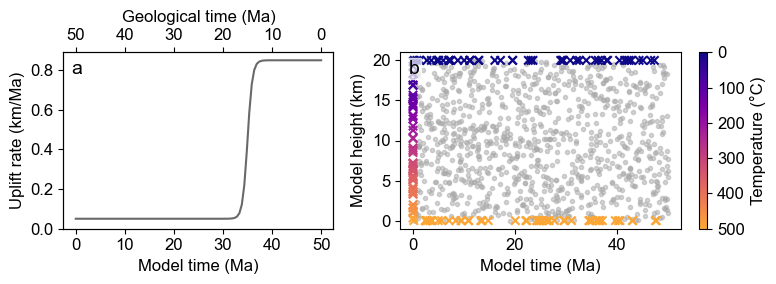

In [8]:
model_t = np.linspace(0, t_end, 100)
fig, axs = plt.subplots(figsize=(8, 3), ncols=2, 
                       width_ratios=(1, 1.3))
# plot uplift model
axs[0].plot(model_t, uplift(model_t), color='dimgray')
axs[0].set_yticks(np.arange(0, 1, .2))
axs[0].set_xticks(range(0, 51, 10))
axs[0].set_xlabel('Model time (Ma)')
axs[0].set_ylabel('Uplift rate (km/Ma)')
ax1 = axs[0].twiny()
ax1.set_xlim(axs[0].get_xlim()[::-1])
ax1.set_xticks(axs[0].get_xticks())
ax1.set_xlabel('Geological time (Ma)');

# Show all collocation points (gray) and 
# boundary conditions (crosses)
axs[1].scatter(t_r, z_r, c='darkgray', marker='.', alpha=.5)
im = axs[1].scatter(X_data.numpy()[:, 0], X_data.numpy()[:, 1],
                    c=T_data.numpy(), marker='x', cmap=cmap,
                    vmin=0, vmax=500) 
axs[1].set_xlabel('Model time (Ma)')
axs[1].set_ylabel('Model height (km)')
# ax.set_title('Positions of collocation points and boundary data')
cb = fig.colorbar(im, ax=axs[1])
cb.ax.invert_yaxis()
cb.set_label('Temperature (°C)')

for ax, s in zip(axs, 'ab'):
    ax.text(.03, .88, s, fontsize=14, transform=ax.transAxes,
           bbox=dict(facecolor='white', edgecolor='white', alpha=.7, pad=1))

fig.tight_layout()
# fig.savefig('plots/1d_icbc.pdf')

In [9]:
from time import time # Initialize model
model = PINN1D(lb, ub)
model.build(input_shape=(None, 2))

# Initilize PINN solver
solver = PINN1DSolver(model, X_r)
solver.fun_u = tf_uplift

# Start timer
t0 = time()

# Solving with Adam
lr = 1e-3
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 5000],[1e-2, 1e-3, 1e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)
solver.solve_with_Adam(optim, X_data, T_data, echofreq=100, savefreq=100, N=5000)
    
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

230814_1749 It   100: loss = 1.52377529e+04: run time = 7 seconds
230814_1749 It   200: loss = 7.32408789e+03: run time = 11 seconds
230814_1749 It   300: loss = 5.07267969e+03: run time = 14 seconds
230814_1749 It   400: loss = 3.53654883e+03: run time = 16 seconds
230814_1749 It   500: loss = 2.56616699e+03: run time = 19 seconds
230814_1749 It   600: loss = 1.93341235e+03: run time = 21 seconds
230814_1749 It   700: loss = 1.50002051e+03: run time = 23 seconds
230814_1749 It   800: loss = 1.19554346e+03: run time = 26 seconds
230814_1749 It   900: loss = 9.68228271e+02: run time = 30 seconds
230814_1749 It  1000: loss = 7.81780151e+02: run time = 32 seconds
230814_1749 It  1100: loss = 6.17943115e+02: run time = 36 seconds
230814_1749 It  1200: loss = 4.70138702e+02: run time = 39 seconds
230814_1749 It  1300: loss = 3.41208740e+02: run time = 41 seconds
230814_1749 It  1400: loss = 2.38295090e+02: run time = 43 seconds
230814_1749 It  1500: loss = 1.64290161e+02: run time = 45 seco

In [11]:
N = 100
t_pred = t_end
tspace = np.ones(N) * t_pred
zspace = np.linspace(lb[1],ub[1], 100)
Xgrid = np.vstack([tspace, zspace]).T

In [12]:
nz = 101
dy = h/(nz-1)
tt = np.linspace(0, t_pred, N)
dt = tt[1] - tt[0]
profileT = np.linspace(Tbot, Tsurf, nz)
profileZ = np.linspace(0, h, nz)

geo_time = tt[::-1]
up0 = uplift(tt)
up = np.mean([up0[:-1], up0[1:]], axis=0)

tm, tp = compute_tt(geo_time, up, kappa=kappa, dt=dt, plot=False,
                    sealevel_t=Tsurf, base_t=Tbot, model_thick=h)

for t in tt:
    profileT = diffusion1d(profileT, dy, dt, kappa)
    u = uplift(t)
    profileT = advect1d(profileT, dy, dt, u)

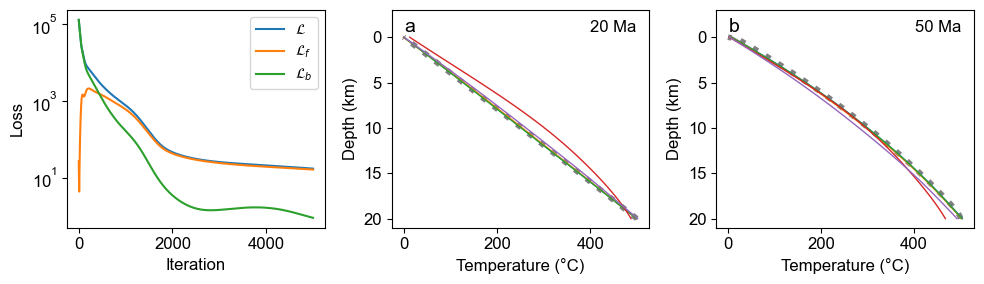

In [38]:
from glob import glob

fig, axs = plt.subplots(figsize=(10, 3), ncols=3, nrows=1)
ages = [20, 50]

for loss, la in zip(['loss', 'heat', 'bound'],
                ['$\mathcal{L}$', '$\mathcal{L}_f$', '$\mathcal{L}_b$']):
    hist = np.load('saved_model/'+ solver.runname + '/' + loss + '_hist.npy')
    
    line_loss = axs[0]
    axs[0].plot(hist, label=la)
    
axs[0].set_yscale('log')
# axs[0].set_yticks(np.logspace(0, 5, 6))
axs[0].legend()
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')

folder = 'saved_model/' + solver.runname + '/*000'

for ax, t_pred, s in zip(axs[1:], ages, 'ab'):
    tt = np.linspace(0, t_pred, N)
    dt = tt[1] - tt[0]
    geo_time = tt[::-1]
    up0 = uplift(tt)
    up = np.mean([up0[:-1], up0[1:]], axis=0)
    tm, tp = compute_tt(geo_time, up, kappa=kappa, dt=dt, plot=False,
                        sealevel_t=Tsurf, base_t=Tbot, model_thick=h)
    for t in tt:
        profileT = diffusion1d(profileT, dy, dt, kappa)
        u = uplift(t)
        profileT = advect1d(profileT, dy, dt, u)
    
    ax.plot(profileT, h-profileZ, ':', color='gray', linewidth=4, label='FEM')
    tspace = np.ones(N) * t_pred
    Xgrid = np.vstack([tspace, zspace]).T
    for path in glob(folder):
        # path = folder + str(i)
        loaded_model = tf.saved_model.load(path)
        pred = loaded_model(tf.cast(Xgrid, DTYPE))
        pred = np.array(pred).T[0]
        ax.plot(pred, h-zspace, linewidth=1)
    
    ax.invert_yaxis()
    ylim0, ylim1 = ax.get_ylim()
    ax.set_ylim(ylim0, -3)
    ax.text(.05, .9, s, fontsize=14, transform=ax.transAxes)
    ax.text(.95, .9, '{} Ma'.format(t_pred), fontsize=12,
            transform=ax.transAxes, horizontalalignment='right')
    
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Depth (km)')
    
# axs[0].legend(loc='lower left')

fig.tight_layout()